In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Read in trip data
trip_data = pd.read_csv('./Dataset/Citibike Data/Citibike Trip Count Data 2017.csv')

# Read in weather data
weather_data = pd.read_csv('./Dataset/Weather Data/Daily NY Weather Cleaned.csv')

In [2]:
# Generate a data frame that has two columns:
  # Date: from 2017-01-01 to 2017-12-31
  # Holiday Dummy: 1 if the day is a holiday/weekend and 0 otherwise

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

date_col = pd.date_range(start='2017-01-01', end='2017-12-31')
df_temp = pd.DataFrame()
df_temp['Date'] = date_col

In [3]:
cal = calendar()
holidays = cal.holidays(start=date_col.min(), end=date_col.max())
df_temp['Holiday'] = df_temp['Date'].isin(holidays)

In [4]:
dow = date_col.dayofweek // 5 == 1

In [5]:
df_temp['Weekend'] = dow

In [6]:
df_temp['Non-business Day'] = df_temp.Holiday | df_temp.Weekend

In [7]:
df_temp.drop(columns=['Holiday', 'Weekend'], inplace=True)

In [8]:
df_temp.Date = df_temp.Date.astype(str)

In [9]:
# Add a dummy Non-business Day column to the primary data frame

trip_data = trip_data.merge(df_temp, how='left', on='Date')

In [15]:
# Join weather data into the primary data frame

trip_data = trip_data.merge(weather_data, how='left', left_on='Date', right_on='DATE_ONLY')

In [17]:
trip_data.drop(columns=['DATE_ONLY'], inplace=True)

In [22]:
# Save the final data frame in a csv file

trip_data.to_csv('Citibike Trip Final.csv', index=False)

### Identify 5 stations that underwent the most traffic

In [26]:
grp = trip_data[['Station ID', 'Departures', 'Arrivals']].groupby(trip_data['Station ID'])
grp.sum().sort_values('Departures', ascending=False).head(10)

,Station ID,Departures,Arrivals
Station ID,,,
519,4064289,162716,160387
497,3794098,112218,117318
402,3005754,108590,116509
435,3343845,107133,108457
426,3101280,105610,114511
3255,25607085,97083,98780
490,3923430,94872,90574
459,3380535,90718,96123
514,3497256,86833,89914


In [27]:
grp.sum().sort_values('Arrivals', ascending=False).head(10)

,Station ID,Departures,Arrivals
Station ID,,,
519,4064289,162716,160387
497,3794098,112218,117318
402,3005754,108590,116509
426,3101280,105610,114511
435,3343845,107133,108457
3255,25607085,97083,98780
459,3380535,90718,96123
490,3923430,94872,90574
514,3497256,86833,89914


It turns out that, either by the number of departures or by the number of arrivals, the 5 busiest stations are Stations __519__, __497__, __402__, __435__, __426__.

## Create two data frames for morning rush hours and evening rush hours on business days

In [283]:
df_temp = trip_data[['Station ID', 'Date', 'Start Hour', 'Departures', 'Arrivals', 'Non-business Day']]

In [286]:
df_temp = df_temp.loc[df_temp['Non-business Day'] == False]

### Morning rush hours (7:00 - 10:00)

In [373]:
grp_mrh = df_temp.loc[(df_temp['Start Hour'] >= 7) & (df_temp['Start Hour'] <= 9)].groupby([df_temp['Station ID'], df_temp['Date']])

In [374]:
df_mrh = grp_mrh.sum().mean(level='Station ID')/3

In [375]:
df_mrh = df_mrh[['Departures', 'Arrivals']]

In [376]:
df_mrh['Net Arrivals'] = df_mrh.Arrivals - df_mrh.Departures

In [377]:
df_mrh = df_mrh.reset_index()

In [378]:
geo_station = pd.read_csv('Stations and Locations.csv')

In [379]:
df_mrh = df_mrh.merge(geo_station, how='inner', on='Station ID')

In [381]:
df_mrh.to_csv('Citibike Morning Hours.csv', index=False)

### Evening rush hours (17:00 - 20:00)

In [382]:
grp_erh = df_temp.loc[(df_temp['Start Hour'] >= 17) & (df_temp['Start Hour'] <= 19)].groupby([df_temp['Station ID'], df_temp['Date']])
df_erh = grp_erh.sum().mean(level='Station ID')/3
df_erh = df_erh[['Departures', 'Arrivals']]
df_erh['Net Arrivals'] = df_erh.Arrivals - df_erh.Departures
df_erh = df_erh.reset_index()
df_erh = df_erh.merge(geo_station, how='inner', on='Station ID')

In [395]:
df_erh.to_csv('Citibike Evening Hours.csv', index=False)

## All Days

### Plot the average hourly departures/arrivals on all days

In [28]:
df_519 = trip_data.loc[trip_data['Station ID'] == 519]
df_497 = trip_data.loc[trip_data['Station ID'] == 497]
df_402 = trip_data.loc[trip_data['Station ID'] == 402]
df_435 = trip_data.loc[trip_data['Station ID'] == 435]
df_426 = trip_data.loc[trip_data['Station ID'] == 426]

In [30]:
grp_519 = df_519[['Start Hour', 'Departures', 'Arrivals']].groupby(df_519['Start Hour'])
grp_497 = df_497[['Start Hour', 'Departures', 'Arrivals']].groupby(df_497['Start Hour'])
grp_402 = df_402[['Start Hour', 'Departures', 'Arrivals']].groupby(df_402['Start Hour'])
grp_435 = df_435[['Start Hour', 'Departures', 'Arrivals']].groupby(df_435['Start Hour'])
grp_426 = df_426[['Start Hour', 'Departures', 'Arrivals']].groupby(df_426['Start Hour'])

In [35]:
avg_519 = grp_519.sum() / 365
avg_497 = grp_497.sum() / 365
avg_402 = grp_402.sum() / 365
avg_435 = grp_435.sum() / 365
avg_426 = grp_426.sum() / 365

In [50]:
import altair as alt
alt.renderers.enable('notebook')
# Plot the hourly average traffic

# By departure

# Construct a data frame for plotting

### Plot the average hourly traffic (departures + arrivals) on all days

In [65]:
traffic_df = pd.DataFrame({'Hour': np.arange(24), 'Station 519': avg_519.Departures + avg_519.Arrivals, 'Station 497': avg_497.Departures + avg_497.Arrivals, 'Station 402': avg_402.Departures + avg_402.Arrivals, 'Station 435': avg_435.Departures + avg_435.Arrivals, 'Station 426': avg_426.Departures + avg_426.Arrivals})
traffic_df = traffic_df.melt('Hour', var_name='Station ID', value_name='Total Traffic')

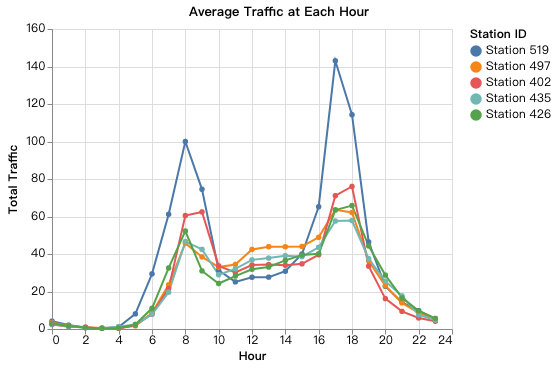

In [273]:
traffic_plot = alt.Chart(traffic_df).mark_line(point=True).encode(
    x='Hour',
    y='Total Traffic',
    color=alt.Color('Station ID', scale=alt.Scale(domain=['Station 519', 'Station 497', 'Station 402', 'Station 435', 'Station 426'],
                                             range=['#4c78a8', '#f58518', '#e45756', '#72b7b2', '#54a24b']))
).configure(background='white')

traffic_plot.title = 'Average Traffic at Each Hour'

traffic_plot.display()

### Plot the average hourly net arrivals (arrivals - departures) on all days

In [80]:
net_arv_df = pd.DataFrame({'Hour': np.arange(24), 'Station 519': avg_519.Arrivals - avg_519.Departures, 'Station 497': avg_497.Arrivals - avg_497.Departures, 'Station 402': avg_402.Arrivals - avg_402.Departures, 'Station 435': avg_435.Arrivals - avg_435.Departures, 'Station 426': avg_426.Arrivals - avg_426.Departures})
net_arv_df = net_arv_df.melt('Hour', var_name='Station ID', value_name='Net Arrivals')

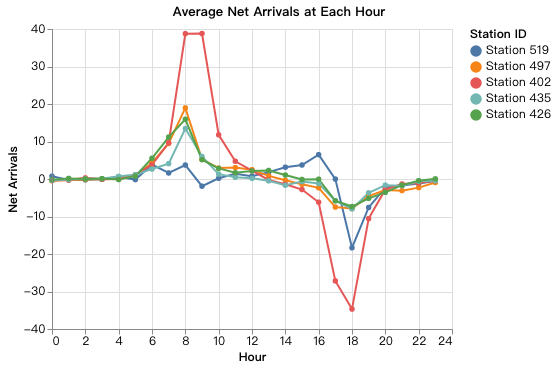

In [274]:
net_arv_plot = alt.Chart(net_arv_df).mark_line(point=True).encode(
    x='Hour',
    y='Net Arrivals',
    color=alt.Color('Station ID', scale=alt.Scale(domain=['Station 519', 'Station 497', 'Station 402', 'Station 435', 'Station 426'],
                                             range=['#4c78a8', '#f58518', '#e45756', '#72b7b2', '#54a24b']))
).configure(background='white')

net_arv_plot.title = 'Average Net Arrivals at Each Hour'

net_arv_plot.display()

## Business Days vs. Non-business Days

In [90]:
# Grouping
grp_519_b = df_519.loc[df_519['Non-business Day'] == False][['Start Hour', 'Departures', 'Arrivals']].groupby(df_519['Start Hour'])
grp_497_b = df_497.loc[df_497['Non-business Day'] == False][['Start Hour', 'Departures', 'Arrivals']].groupby(df_497['Start Hour'])
grp_402_b = df_402.loc[df_402['Non-business Day'] == False][['Start Hour', 'Departures', 'Arrivals']].groupby(df_402['Start Hour'])

grp_519_nb = df_519.loc[df_519['Non-business Day'] == True][['Start Hour', 'Departures', 'Arrivals']].groupby(df_519['Start Hour'])
grp_497_nb = df_497.loc[df_497['Non-business Day'] == True][['Start Hour', 'Departures', 'Arrivals']].groupby(df_497['Start Hour'])
grp_402_nb = df_402.loc[df_402['Non-business Day'] == True][['Start Hour', 'Departures', 'Arrivals']].groupby(df_402['Start Hour'])

In [92]:
avg_519_b = grp_519_b.mean()
avg_497_b = grp_497_b.mean()
avg_402_b = grp_402_b.mean()

avg_519_nb = grp_519_nb.mean()
avg_497_nb = grp_497_nb.mean()
avg_402_nb = grp_402_nb.mean()

### Plot the average hourly traffic on business days vs. non-business days

In [111]:
# Traffic

# Create data frames for plotting
traffic_b_df = pd.DataFrame({'Hour': np.arange(24), 'Station 519': avg_519_b.Arrivals + avg_519_b.Departures, 'Station 497': avg_497_b.Arrivals + avg_497_b.Departures, 'Station 402': avg_402_b.Arrivals + avg_402_b.Departures})
traffic_b_df = traffic_b_df.melt('Hour', var_name='Station ID', value_name='Total Traffic')

traffic_nb_df = pd.DataFrame({'Hour': np.arange(24), 'Station 519': avg_519_nb.Arrivals + avg_519_nb.Departures, 'Station 497': avg_497_nb.Arrivals + avg_497_nb.Departures, 'Station 402': avg_402_nb.Arrivals + avg_402.Departures})
traffic_nb_df = traffic_nb_df.melt('Hour', var_name='Station ID', value_name='Total Traffic')

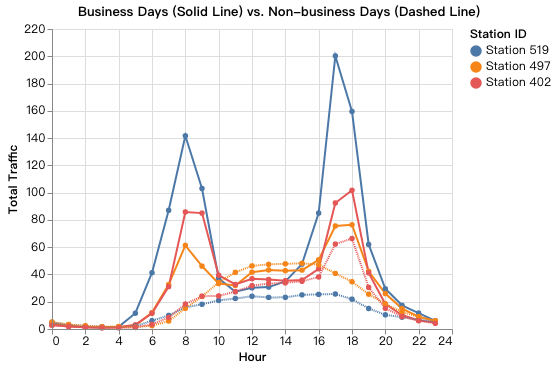

In [276]:
# Plot

traffic_b_plot = alt.Chart(traffic_b_df).mark_line(point=True).encode(
    x='Hour',
    y='Total Traffic',
    color=alt.Color('Station ID', scale=alt.Scale(domain=['Station 519', 'Station 497', 'Station 402'],
                                             range=['#4c78a8', '#f58518', '#e45756']))
)

traffic_nb_plot = alt.Chart(traffic_nb_df).mark_line(point=True, strokeDash=[1, 1]).encode(
    x='Hour',
    y='Total Traffic',
    color=alt.Color('Station ID', scale=alt.Scale(domain=['Station 519', 'Station 497', 'Station 402'],
                                             range=['#4c78a8', '#f58518', '#e45756']))
)

traffic_b_nb_plot = traffic_b_plot + traffic_nb_plot

traffic_b_nb_plot.title = 'Business Days (Solid Line) vs. Non-business Days (Dashed Line)'
traffic_b_nb_plot = traffic_b_nb_plot.configure(background='white')

traffic_b_nb_plot.display()

### Plot the average hourly net arrivals on business days vs. non-business days

In [115]:
# Traffic

# Create data frames for plotting
net_arv_b_df = pd.DataFrame({'Hour': np.arange(24), 'Station 519': avg_519_b.Arrivals - avg_519_b.Departures, 'Station 497': avg_497_b.Arrivals - avg_497_b.Departures, 'Station 402': avg_402_b.Arrivals - avg_402_b.Departures})
net_arv_b_df = net_arv_b_df.melt('Hour', var_name='Station ID', value_name='Net Arrivals')

net_arv_nb_df = pd.DataFrame({'Hour': np.arange(24), 'Station 519': avg_519_nb.Arrivals - avg_519_nb.Departures, 'Station 497': avg_497_nb.Arrivals - avg_497_nb.Departures, 'Station 402': avg_402_nb.Arrivals - avg_402.Departures})
net_arv_nb_df = net_arv_nb_df.melt('Hour', var_name='Station ID', value_name='Net Arrivals')

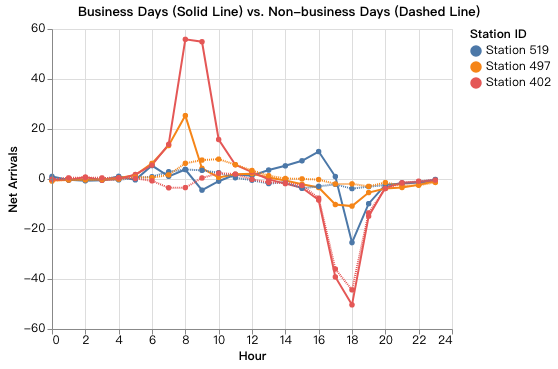

In [277]:
# Plot

net_arv_b_plot = alt.Chart(net_arv_b_df).mark_line(point=True).encode(
    x='Hour',
    y='Net Arrivals',
    color=alt.Color('Station ID', scale=alt.Scale(domain=['Station 519', 'Station 497', 'Station 402'],
                                             range=['#4c78a8', '#f58518', '#e45756']))
)

net_arv_nb_plot = alt.Chart(net_arv_nb_df).mark_line(point=True, strokeDash=[1, 1]).encode(
    x='Hour',
    y='Net Arrivals',
    color=alt.Color('Station ID', scale=alt.Scale(domain=['Station 519', 'Station 497', 'Station 402'],
                                             range=['#4c78a8', '#f58518', '#e45756']))
)

net_arv_b_nb_plot = net_arv_b_plot + net_arv_nb_plot

net_arv_b_nb_plot.title = 'Business Days (Solid Line) vs. Non-business Days (Dashed Line)'
net_arv_b_nb_plot = net_arv_b_nb_plot.configure(background='white')

net_arv_b_nb_plot.display()

# Impact of Inclement Weather on Trips

We will examine the impact of inclement weather on the number of trips associated with the top 5 Citibike stations. More specifically, we will create combined bar-line plots on three types of inclement weather (rain, snow and gust). Note that only trips that occurred on business days will be considered.

In [131]:
weather_data = weather_data.merge(df_temp, how='left', left_on='DATE_ONLY', right_on='Date')
weather_data.drop(columns=['DATE_ONLY'], inplace=True)

In [133]:
weather_b = weather_data.loc[weather_data['Non-business Day'] == False]

In [192]:
# Total number of trips on each business day

traffic_date_519 = df_519.loc[df_519['Non-business Day'] == False][['Departures', 'Arrivals']].groupby(df_519['Date']).sum()
traff_519 = pd.DataFrame({'Station ID': 'Station 519', 'Log Traffic': np.log(traffic_date_519.Departures + traffic_date_519.Arrivals)}).reset_index()

traffic_date_497 = df_497.loc[df_497['Non-business Day'] == False][['Departures', 'Arrivals']].groupby(df_497['Date']).sum()
traff_497 = pd.DataFrame({'Station ID': 'Station 497', 'Log Traffic': np.log(traffic_date_497.Departures + traffic_date_497.Arrivals)}).reset_index()

traffic_date_402 = df_402.loc[df_402['Non-business Day'] == False][['Departures', 'Arrivals']].groupby(df_402['Date']).sum()
traff_402 = pd.DataFrame({'Station ID': 'Station 402', 'Log Traffic': np.log(traffic_date_402.Departures + traffic_date_402.Arrivals)}).reset_index()

In [193]:
df_traff_b = traff_519.append(traff_497).append(traff_402)

## Rain (Precipitation)

In [248]:
precip = weather_b[['DAILYPrecip', 'Date']]

In [249]:
precip = precip.rename(index=str, columns={'DAILYPrecip': 'Daily Precipitation'})

In [250]:
df_traff_precip = df_traff_b.merge(precip, how='left', on='Date')

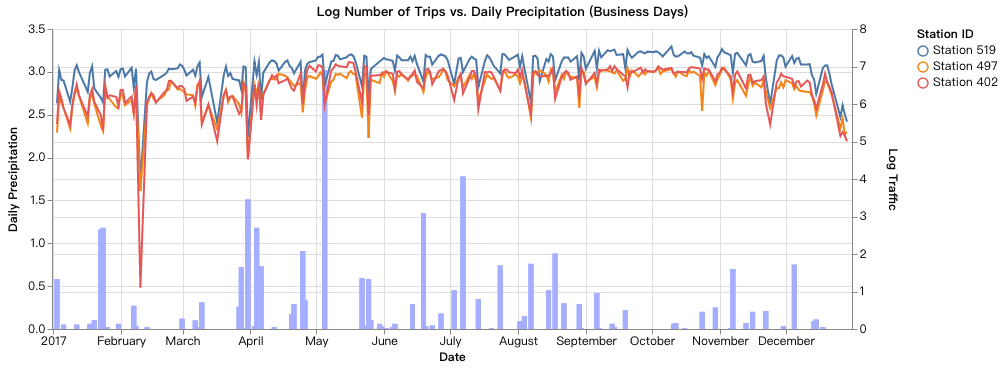

In [279]:
base = alt.Chart(df_traff_precip).encode(
    alt.X('Date:T')
)

traff_y = base.mark_line().encode(
    y='Log Traffic:Q',
    color=alt.Color('Station ID', scale=alt.Scale(domain=['Station 519', 'Station 497', 'Station 402'],
                                             range=['#4c78a8', '#f58518', '#e45756']))
)

precip_y = base.mark_bar().encode(
    y='Daily Precipitation:Q',
    color=alt.ColorValue('#A5AEFF'),
)

traff_precip = alt.layer(
    precip_y,
    traff_y
).resolve_scale(
    y='independent'
).configure(background='white')

traff_precip.title = 'Log Number of Trips vs. Daily Precipitation (Business Days)'
traff_precip.width = 800
traff_precip.display()

## Snowfall

In [261]:
snowfall = weather_b[['DAILYSnowfall', 'Date']]
snowfall = snowfall.rename(index=str, columns={'DAILYSnowfall': 'Daily Snowfall'})
df_traff_snowfall = df_traff_b.merge(snowfall, how='left', on='Date')

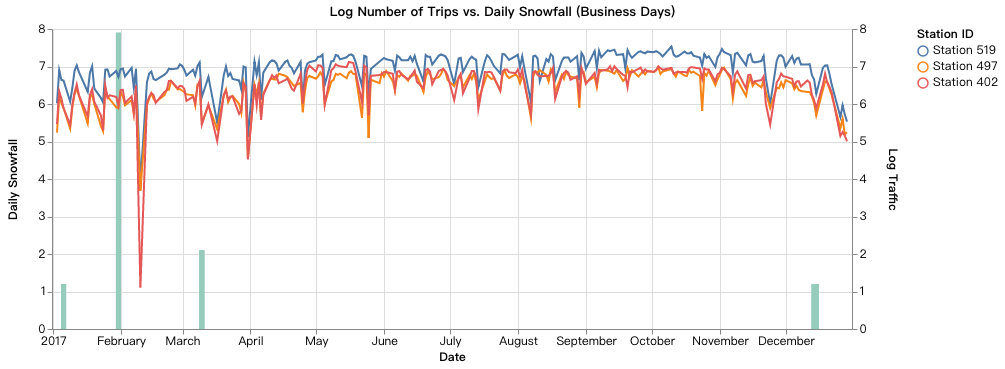

In [280]:
base = alt.Chart(df_traff_snowfall).encode(
    alt.X('Date:T')
)

traff_y = base.mark_line().encode(
    y='Log Traffic:Q',
    color=alt.Color('Station ID', scale=alt.Scale(domain=['Station 519', 'Station 497', 'Station 402'],
                                             range=['#4c78a8', '#f58518', '#e45756']))
)

snowfall_y = base.mark_bar().encode(
    y='Daily Snowfall:Q',
    color=alt.ColorValue('#96ccbc'),
)

traff_snowfall = alt.layer(
    snowfall_y,
    traff_y
).resolve_scale(
    y='independent'
).configure(background='white')

traff_snowfall.title = 'Log Number of Trips vs. Daily Snowfall (Business Days)'
traff_snowfall.width = 800
traff_snowfall.display()

## Snow Depth

In [255]:
snow_depth = weather_b[['DAILYSnowDepth', 'Date']]
snow_depth = snow_depth.rename(index=str, columns={'DAILYSnowDepth': 'Daily Snow Depth'})
df_traff_snow_depth = df_traff_b.merge(snow_depth, how='left', on='Date')

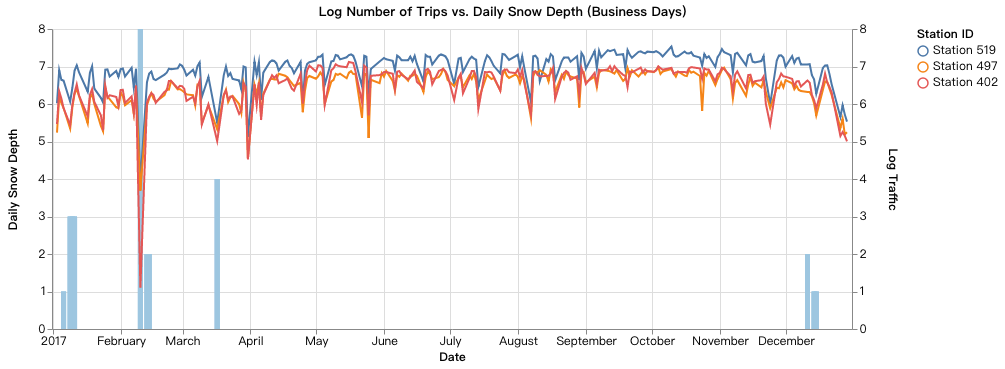

In [281]:
base = alt.Chart(df_traff_snow_depth).encode(
    alt.X('Date:T')
)

traff_y = base.mark_line().encode(
    y='Log Traffic:Q',
    color=alt.Color('Station ID', scale=alt.Scale(domain=['Station 519', 'Station 497', 'Station 402'],
                                             range=['#4c78a8', '#f58518', '#e45756']))
)

snow_depth_y = base.mark_bar().encode(
    y='Daily Snow Depth:Q',
    color=alt.ColorValue('#9dc6e0'),
)

traff_snow_depth = alt.layer(
    snow_depth_y,
    traff_y
).resolve_scale(
    y='independent'
).configure(background='white')

traff_snow_depth.title = 'Log Number of Trips vs. Daily Snow Depth (Business Days)'
traff_snow_depth.width = 800
traff_snow_depth.display()

## Correlation Heat Map

In [403]:
trips = trip_data[['Date', 'Departures']]
grp_trips = trips.groupby(trips['Date'])

In [413]:
df_trips = grp_trips.sum().reset_index().rename(index=str, columns={'Departures': 'Trips'})

In [409]:
date_col = pd.date_range(start='2017-01-01', end='2017-12-31')
df_t = pd.DataFrame()
df_t['Date'] = date_col
cal = calendar()
holidays = cal.holidays(start=date_col.min(), end=date_col.max())
df_t['Holiday'] = df_t['Date'].isin(holidays)
dow = date_col.dayofweek // 5 == 1
df_t['Weekend'] = dow
df_t['Non-business Day'] = df_t.Holiday | df_t.Weekend
df_t.drop(columns=['Holiday', 'Weekend'], inplace=True)
df_t.Date = df_t.Date.astype(str)

In [417]:
w_data = pd.read_csv('./Dataset/Weather Data/Daily NY Weather Cleaned.csv')
w_data = w_data.rename(index=str, columns={'DATE_ONLY': 'Date'})

In [418]:
df_trips = df_trips.merge(df_t, how='left', on='Date').merge(w_data, how='left', on='Date')

In [420]:
df_trips.drop(columns=['Date'], inplace=True)

In [422]:
corr_matrix = df_trips.corr()

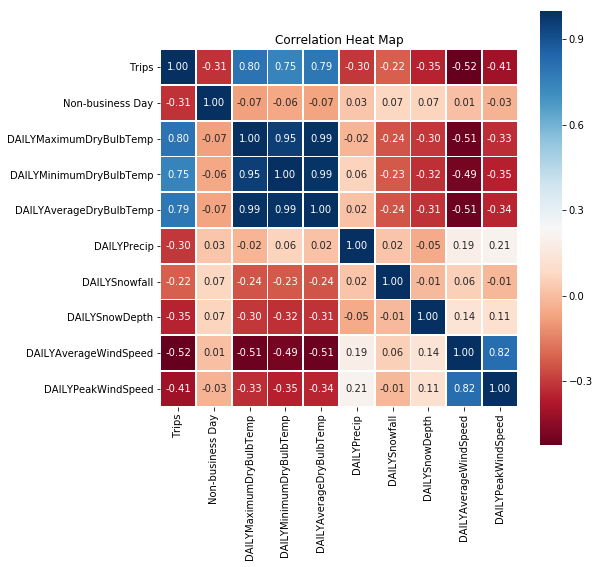

In [436]:
import seaborn as sns

fig = plt.figure(figsize=(8,8))
plt.title('Correlation Heat Map')
fig.set_facecolor('white')
sns.heatmap(corr_matrix, annot = True, fmt='.2f', linewidth = .8, square = True, cmap = 'RdBu')
plt.show()